# Datos raster y combinación con datos vectoriales y multidimensionales

[Emilio Mayorga, University of Washington](https://github.com/emiliom/). 2023-02-28

In [1]:
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt

from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame

In [2]:
import rasterio
import rasterio.plot as rioplot

In [3]:
datos_ruta = Path("./datos")

## Leer y procesar la batimetría raster

Con `rasterio`, https://rasterio.readthedocs.io

In [4]:
elevacion = rasterio.open(datos_ruta / "etopo1_conosur_180.tif")

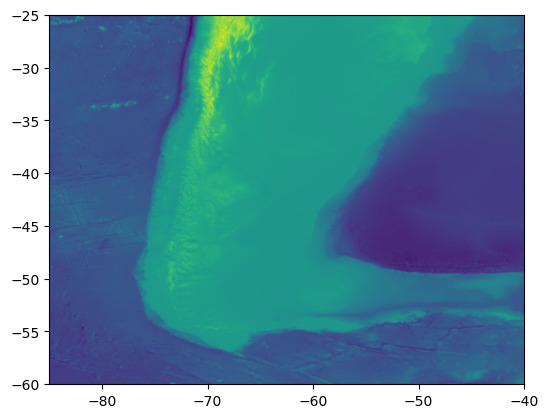

In [5]:
rioplot.show(elevacion);

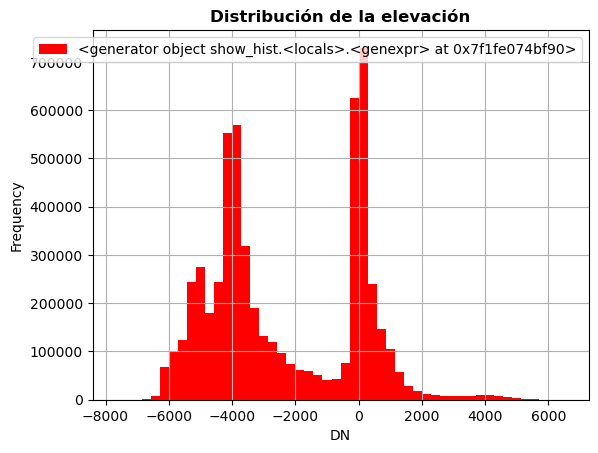

In [6]:
rioplot.show_hist(elevacion, bins=50, title='Distribución de la elevación')

Examinemos el objeto raster que hemos creado, sus atributos

In [7]:
type(elevacion)

rasterio.io.DatasetReader

In [8]:
elevacion

<open DatasetReader name='datos/etopo1_conosur_180.tif' mode='r'>

In [9]:
elevacion.meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': -32768.0,
 'width': 2701,
 'height': 2101,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.016666666666666666, 0.0, -85.00833333333334,
        0.0, -0.016666666666666666, -24.991666666666667)}

In [10]:
elevacion.nodata

-32768.0

In [11]:
elevacion.bounds

BoundingBox(left=-85.00833333333334, bottom=-60.00833333333333, right=-39.991666666666674, top=-24.991666666666667)

In [12]:
banda1 = elevacion.read(1)

In [13]:
type(banda1), banda1.shape

(numpy.ndarray, (2101, 2701))

### Procesemos los datos de elevación para crear una versión más apropiada

Eliminar las elevaciones sobre el nivel del mar, y convertir elevaciones negativas a positivas (profundidades)

In [14]:
with rasterio.open('batimetria_conosur.tif', 'w', **elevacion.meta) as batimetria:
    banda1[banda1 >= 0] = int(batimetria.nodata)
    banda1[banda1 < 0] = -1 * banda1[banda1 < 0]
    batimetria.write(banda1, 1)

In [15]:
batimetria = rasterio.open('batimetria_conosur.tif')

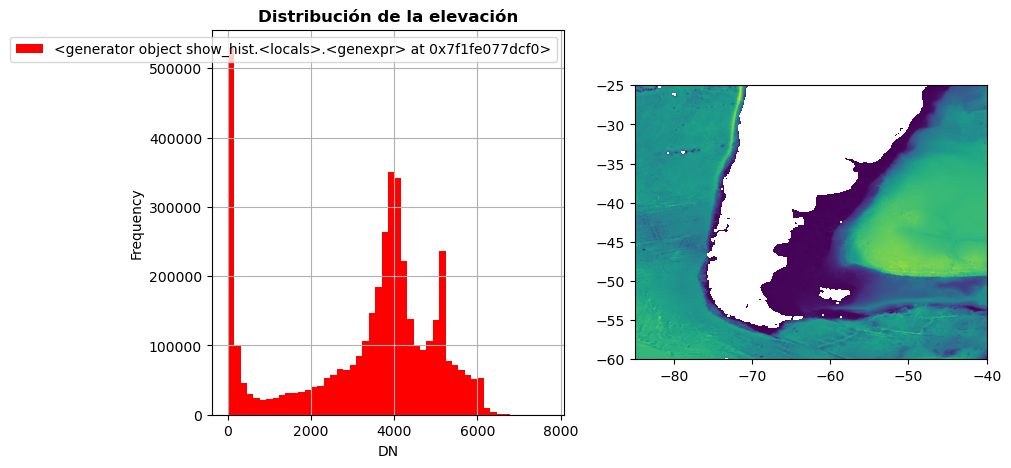

In [16]:
_, ax = plt.subplots(ncols=2, figsize=(10, 5))
rioplot.show_hist(batimetria, bins=50, title='Distribución de la elevación', ax=ax[0])
rioplot.show(batimetria, with_bounds=True, ax=ax[1]);

## Leer los datos poligopnales MEOW

Ecoregiones Marinas del Mundo, MEOW. https://www.worldwildlife.org/publications/marine-ecoregions-of-the-world-a-bioregionalization-of-coastal-and-shelf-areas

In [17]:
ecoregiones_gdf = gpd.read_file(datos_ruta / "meow_ecos.shp")

In [18]:
ecoregiones_gdf.head()

,ECO_CODE,ECOREGION,PROV_CODE,PROVINCE,RLM_CODE,REALM,ALT_CODE,ECO_CODE_X,Lat_Zone,geometry
0,20192.0,Agulhas Bank,51.0,Agulhas,10.0,Temperate Southern Africa,189.0,192.0,Temperate,"POLYGON ((28.35993 -36.64435, 28.28350 -36.676..."
1,20053.0,Aleutian Islands,10.0,Cold Temperate Northeast Pacific,3.0,Temperate Northern Pacific,50.0,53.0,Temperate,"MULTIPOLYGON (((-173.39419 55.59807, -168.5559..."
2,20072.0,Amazonia,13.0,North Brazil Shelf,4.0,Tropical Atlantic,64.0,72.0,Tropical,"POLYGON ((-41.13012 0.47319, -41.03905 0.44390..."
3,20194.0,Amsterdam-St Paul,52.0,Amsterdam-St Paul,10.0,Temperate Southern Africa,191.0,194.0,Temperate,"POLYGON ((77.52994 -34.52290, 77.92307 -34.545..."
4,20228.0,Amundsen/Bellingshausen Sea,61.0,Continental High Antarctic,12.0,Southern Ocean,209.0,228.0,Polar,"POLYGON ((-72.94222 -74.30962, -79.88636 -75.1..."


## Estadísticas zonales de batímetría en las ecoregiones MEOW, con `rasterstats`

`rasterstats`, https://github.com/perrygeo/python-rasterstats

In [19]:
import rasterstats as rs

In [20]:
zonal_bati_geojson = rs.zonal_stats(ecoregiones_gdf, batimetria.files[0], 
                                    prefix='profund_', geojson_out=True)

In [21]:
type(zonal_bati_geojson)

list

In [22]:
zonal_bati_gdf = GeoDataFrame.from_features(zonal_bati_geojson, crs=batimetria.crs)
len(zonal_bati_gdf)

232

In [23]:
zonal_bati_gdf.head(2)

,geometry,ECO_CODE,ECOREGION,PROV_CODE,PROVINCE,RLM_CODE,REALM,ALT_CODE,ECO_CODE_X,Lat_Zone,profund_count,profund_min,profund_max,profund_mean
0,"POLYGON ((28.35993 -36.64435, 28.28350 -36.676...",20192.0,Agulhas Bank,51.0,Agulhas,10.0,Temperate Southern Africa,189.0,192.0,Temperate,0,NaN,NaN,NaN
1,"MULTIPOLYGON (((-173.39419 55.59807, -168.5559...",20053.0,Aleutian Islands,10.0,Cold Temperate Northeast Pacific,3.0,Temperate Northern Pacific,50.0,53.0,Temperate,0,NaN,NaN,NaN


In [24]:
zonal_bati_gdf = zonal_bati_gdf[zonal_bati_gdf.profund_count > 0].copy()

In [25]:
len(zonal_bati_gdf)

16

In [26]:
zonal_bati_gdf.PROVINCE.value_counts()

Magellanic                              5
Warm Temperate Southwestern Atlantic    4
Warm Temperate Southeastern Pacific     3
Scotia Sea                              3
Juan Fernandez and Desventuradas        1
Name: PROVINCE, dtype: int64

### Mapear los resultados usando la herramiento `Folium` de mapeo interactivo

`Folium`, https://python-visualization.github.io/folium/

In [27]:
import folium

In [28]:
centro_lon = 0.5*(batimetria.bounds.right + batimetria.bounds.left)
centro_lat = 0.5*(batimetria.bounds.top + batimetria.bounds.bottom)

In [29]:
m = folium.Map(location=[centro_lat, centro_lon], zoom_start=3, tiles="cartodbpositron")

folium.Choropleth(
    geo_data=zonal_bati_gdf,
    data=zonal_bati_gdf,
    columns=['ECOREGION', 'profund_mean'],
    key_on='feature.properties.ECOREGION',
    legend_name='Profundidad promedio (m)', 
    fill_color='YlGn',
    fill_opacity=0.4,
    highlight=True
).add_to(m)

m

## Extraer serie temporal grid de clorofila satelital, del NOAA CoastWatch ERDDAP 

- Primero vamos al sitio NOAA CoastWatch ERDDAP y exploramos los datasets satelitales de chlorophyll: https://coastwatch.pfeg.noaa.gov/erddap/
- Una vez que identificamos el dataset que queremos, copias el URL para leerlo a través del protocol OPeNDAP por medio de `xarray`
- El dataset será un producto Europeo del programa CCI, que combina sensores de diferentes satelitales Europeos y Norteamericanos

### Primero definamos una región más reducida, la "Provincia Magellanica"

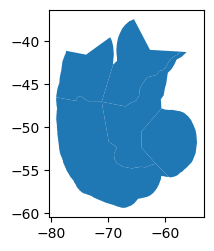

In [30]:
zonal_bati_gdf[zonal_bati_gdf['PROVINCE'] == 'Magellanic'].plot(figsize=(2,3));

De ahí, extraemos las coordenadas de la caja de borde

In [31]:
magellanic_gdf = zonal_bati_gdf[zonal_bati_gdf['PROVINCE'] == 'Magellanic']
magellanic_bordes = magellanic_gdf.geometry.unary_union.bounds

In [32]:
magellanic_bordes

(-79.04860278479299,
 -59.345750739113214,
 -54.400302736409856,
 -37.456820450725616)

In [33]:
import datetime
from pyproj import CRS
import xarray as xr
import rioxarray
import regionmask as rm

In [34]:
magellanic_bordes

(-79.04860278479299,
 -59.345750739113214,
 -54.400302736409856,
 -37.456820450725616)

### Ahora creamos el query a los datos

En los primeros pasos, sólo los metadatos son leídos. El dataset completo es enorme!

In [35]:
erddap_opendap_url = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI60OceanColorMonthly'

esacci_ds = xr.open_dataset(erddap_opendap_url)

In [36]:
esacci_ds

<xarray.Dataset>
Dimensions:             (time: 304, latitude: 4320, longitude: 8640)
Coordinates:
  * time                (time) datetime64[ns] 1997-09-04 ... 2022-12-01
  * latitude            (latitude) float64 89.98 89.94 89.9 ... -89.94 -89.98
  * longitude           (longitude) float64 -180.0 -179.9 -179.9 ... 179.9 180.0
Data variables: (12/93)
    Rrs_412             (time, latitude, longitude) float32 ...
    Rrs_412_bias        (time, latitude, longitude) float32 ...
    Rrs_412_rmsd        (time, latitude, longitude) float32 ...
    Rrs_443             (time, latitude, longitude) float32 ...
    Rrs_443_bias        (time, latitude, longitude) float32 ...
    Rrs_443_rmsd        (time, latitude, longitude) float32 ...
    ...                  ...
    MODISA_nobs_sum     (time, latitude, longitude) float32 ...
    OLCI_A_nobs_sum     (time, latitude, longitude) float32 ...
    OLCI_B_nobs_sum     (time, latitude, longitude) float32 ...
    SeaWiFS_nobs_sum    (time, latitude, longitude) float32 ...
    VIIRS_nobs_sum      (time, latitude, longitude) float32 ...
    total_nobs_sum      (time, latitude, longitude) float32 ...
Attributes: (12/52)
    cdm_data_type:                     Grid
    comment:                           See summary attribute
    Conventions:                       CF-1.7, COARDS, ACDD-1.3
    creation_date:                     Tue Jan 31 12:12:15 2023
    creator_email:                     help@esa-oceancolour-cci.org
    creator_name:                      Plymouth Marine Laboratory
    ...                                ...
    time_coverage_end:                 2022-12-01T00:00:00Z
    time_coverage_resolution:          P1M
    time_coverage_start:               1997-09-04T00:00:00Z
    title:                             ESA CCI Ocean Colour Product (CCI ALL-...
    tracking_id:                       22a88639-2080-46f5-9e01-20507bf3cc5c
    Westernmost_Easting:               -179.97916666666666

In [37]:
esacci_ds.nbytes/1e6 # MB

4220987.088512

**Atención!** El orden original de las dimensiones es importante! Si van de valores bajos a valore altos, o viceversa.

In [38]:
subset_esacci_ds = esacci_ds.sel(
    time=slice(datetime.datetime(2021,1,1), datetime.datetime(2021,12,31)), 
    latitude=slice(magellanic_bordes[3], magellanic_bordes[1]), 
    longitude=slice(magellanic_bordes[0], magellanic_bordes[2])
    
)

In [39]:
subset_esacci_ds

<xarray.Dataset>
Dimensions:             (time: 12, latitude: 525, longitude: 591)
Coordinates:
  * time                (time) datetime64[ns] 2021-01-01 ... 2021-12-01
  * latitude            (latitude) float64 -37.48 -37.52 ... -59.27 -59.31
  * longitude           (longitude) float64 -79.02 -78.98 ... -54.48 -54.44
Data variables: (12/93)
    Rrs_412             (time, latitude, longitude) float32 ...
    Rrs_412_bias        (time, latitude, longitude) float32 ...
    Rrs_412_rmsd        (time, latitude, longitude) float32 ...
    Rrs_443             (time, latitude, longitude) float32 ...
    Rrs_443_bias        (time, latitude, longitude) float32 ...
    Rrs_443_rmsd        (time, latitude, longitude) float32 ...
    ...                  ...
    MODISA_nobs_sum     (time, latitude, longitude) float32 ...
    OLCI_A_nobs_sum     (time, latitude, longitude) float32 ...
    OLCI_B_nobs_sum     (time, latitude, longitude) float32 ...
    SeaWiFS_nobs_sum    (time, latitude, longitude) float32 ...
    VIIRS_nobs_sum      (time, latitude, longitude) float32 ...
    total_nobs_sum      (time, latitude, longitude) float32 ...
Attributes: (12/52)
    cdm_data_type:                     Grid
    comment:                           See summary attribute
    Conventions:                       CF-1.7, COARDS, ACDD-1.3
    creation_date:                     Tue Jan 31 12:12:15 2023
    creator_email:                     help@esa-oceancolour-cci.org
    creator_name:                      Plymouth Marine Laboratory
    ...                                ...
    time_coverage_end:                 2022-12-01T00:00:00Z
    time_coverage_resolution:          P1M
    time_coverage_start:               1997-09-04T00:00:00Z
    title:                             ESA CCI Ocean Colour Product (CCI ALL-...
    tracking_id:                       22a88639-2080-46f5-9e01-20507bf3cc5c
    Westernmost_Easting:               -179.97916666666666

In [40]:
subset_chlora_da = subset_esacci_ds['chlor_a']
subset_chlora_da.nbytes/1e6 # NB

14.8932

### Ahora bajar los datos mucho más reducidos y modestos que hemos solictado

In [41]:
%%time
subset_chlora_da.load()

CPU times: user 112 ms, sys: 83.4 ms, total: 195 ms
Wall time: 24.6 s


<xarray.DataArray 'chlor_a' (time: 12, latitude: 525, longitude: 591)>
array([[[0.30196974, 0.30196974, 0.3109013 , ..., 0.55387276,
         0.49856716, 0.4904751 ],
        [0.3276423 , 0.32885876, 0.32885876, ..., 0.47588772,
         0.47688273, 0.4817938 ],
        [0.35026908, 0.35026908, 0.36911634, ..., 0.47896802,
         0.48155132, 0.48155132],
        ...,
        [0.5684466 , 0.4137013 , 0.4137013 , ..., 1.0614855 ,
         0.83809656, 0.83809656],
        [0.5962343 , 0.5962343 , 0.42581087, ..., 1.2181188 ,
         0.8088437 , 0.8088437 ],
        [0.42060357, 0.39257053, 0.39257053, ..., 0.9917679 ,
         0.9537301 , 0.9537301 ]],

       [[0.37859872, 0.37859872, 0.39994225, ..., 0.61688614,
         0.5894287 , 0.547848  ],
        [0.42402887, 0.4008926 , 0.4008926 , ..., 0.5320298 ,
         0.5431031 , 0.548901  ],
        [0.42024028, 0.42024028, 0.40765426, ..., 0.4822874 ,
         0.5207281 , 0.5207281 ],
...
        [0.14216949, 0.15199646, 0.15199646, ..., 0.17308265,
         0.16803604, 0.16803604],
        [0.15902911, 0.15902911, 0.13814461, ..., 0.17244352,
         0.14078163, 0.14078163],
        [0.14252798, 0.1581811 , 0.1581811 , ..., 0.15122144,
         0.13858482, 0.13858482]],

       [[0.41264024, 0.41264024, 0.43320546, ..., 0.6534586 ,
         0.5645952 , 0.4558687 ],
        [0.42478874, 0.45415094, 0.45415094, ..., 0.5814768 ,
         0.51535636, 0.41463903],
        [0.502674  , 0.502674  , 0.44726843, ..., 0.51970756,
         0.49164236, 0.49164236],
        ...,
        [0.47743097, 0.45121136, 0.45121136, ..., 0.17224012,
         0.17608608, 0.17608608],
        [0.50081503, 0.50081503, 0.46640453, ..., 0.19369593,
         0.17336038, 0.17336038],
        [0.38935214, 0.45898643, 0.45898643, ..., 0.16717109,
         0.16038951, 0.16038951]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2021-01-01 2021-02-01 ... 2021-12-01
  * latitude   (latitude) float64 -37.48 -37.52 -37.56 ... -59.23 -59.27 -59.31
  * longitude  (longitude) float64 -79.02 -78.98 -78.94 ... -54.52 -54.48 -54.44
Attributes:
    ancillary_variables:  chlor_a_log10_rmsd chlor_a_log10_bias
    colorBarMaximum:      30.0
    colorBarMinimum:      0.03
    colorBarScale:        Log
    ioos_category:        Ocean Color
    long_name:            Chlorophyll-a concentration in seawater (not log-tr...
    parameter_vocab_uri:  http://vocab.ndg.nerc.ac.uk/term/P011/current/CHLTVOLU
    standard_name:        mass_concentration_of_chlorophyll_a_in_sea_water
    units:                milligram m-3
    units_nonstandard:    mg m^-3

In [42]:
subset_chlora_da

<xarray.DataArray 'chlor_a' (time: 12, latitude: 525, longitude: 591)>
array([[[0.30196974, 0.30196974, 0.3109013 , ..., 0.55387276,
         0.49856716, 0.4904751 ],
        [0.3276423 , 0.32885876, 0.32885876, ..., 0.47588772,
         0.47688273, 0.4817938 ],
        [0.35026908, 0.35026908, 0.36911634, ..., 0.47896802,
         0.48155132, 0.48155132],
        ...,
        [0.5684466 , 0.4137013 , 0.4137013 , ..., 1.0614855 ,
         0.83809656, 0.83809656],
        [0.5962343 , 0.5962343 , 0.42581087, ..., 1.2181188 ,
         0.8088437 , 0.8088437 ],
        [0.42060357, 0.39257053, 0.39257053, ..., 0.9917679 ,
         0.9537301 , 0.9537301 ]],

       [[0.37859872, 0.37859872, 0.39994225, ..., 0.61688614,
         0.5894287 , 0.547848  ],
        [0.42402887, 0.4008926 , 0.4008926 , ..., 0.5320298 ,
         0.5431031 , 0.548901  ],
        [0.42024028, 0.42024028, 0.40765426, ..., 0.4822874 ,
         0.5207281 , 0.5207281 ],
...
        [0.14216949, 0.15199646, 0.15199646, ..., 0.17308265,
         0.16803604, 0.16803604],
        [0.15902911, 0.15902911, 0.13814461, ..., 0.17244352,
         0.14078163, 0.14078163],
        [0.14252798, 0.1581811 , 0.1581811 , ..., 0.15122144,
         0.13858482, 0.13858482]],

       [[0.41264024, 0.41264024, 0.43320546, ..., 0.6534586 ,
         0.5645952 , 0.4558687 ],
        [0.42478874, 0.45415094, 0.45415094, ..., 0.5814768 ,
         0.51535636, 0.41463903],
        [0.502674  , 0.502674  , 0.44726843, ..., 0.51970756,
         0.49164236, 0.49164236],
        ...,
        [0.47743097, 0.45121136, 0.45121136, ..., 0.17224012,
         0.17608608, 0.17608608],
        [0.50081503, 0.50081503, 0.46640453, ..., 0.19369593,
         0.17336038, 0.17336038],
        [0.38935214, 0.45898643, 0.45898643, ..., 0.16717109,
         0.16038951, 0.16038951]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2021-01-01 2021-02-01 ... 2021-12-01
  * latitude   (latitude) float64 -37.48 -37.52 -37.56 ... -59.23 -59.27 -59.31
  * longitude  (longitude) float64 -79.02 -78.98 -78.94 ... -54.52 -54.48 -54.44
Attributes:
    ancillary_variables:  chlor_a_log10_rmsd chlor_a_log10_bias
    colorBarMaximum:      30.0
    colorBarMinimum:      0.03
    colorBarScale:        Log
    ioos_category:        Ocean Color
    long_name:            Chlorophyll-a concentration in seawater (not log-tr...
    parameter_vocab_uri:  http://vocab.ndg.nerc.ac.uk/term/P011/current/CHLTVOLU
    standard_name:        mass_concentration_of_chlorophyll_a_in_sea_water
    units:                milligram m-3
    units_nonstandard:    mg m^-3

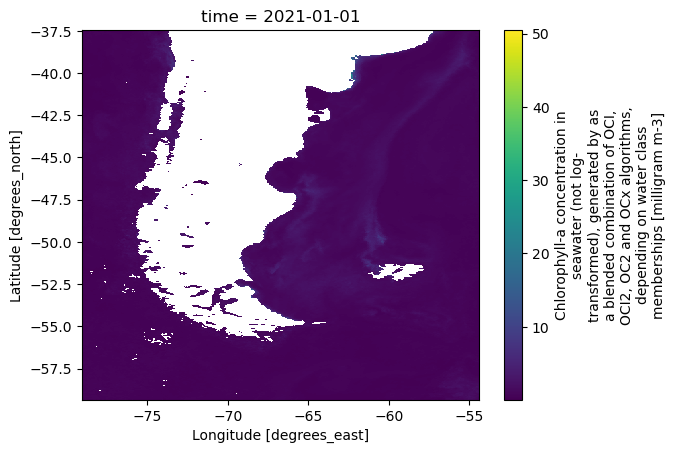

In [43]:
subset_chlora_da.isel(time=0).plot()

In [44]:
chlora_xypromedio = subset_chlora_da.mean(dim=('latitude', 'longitude'))

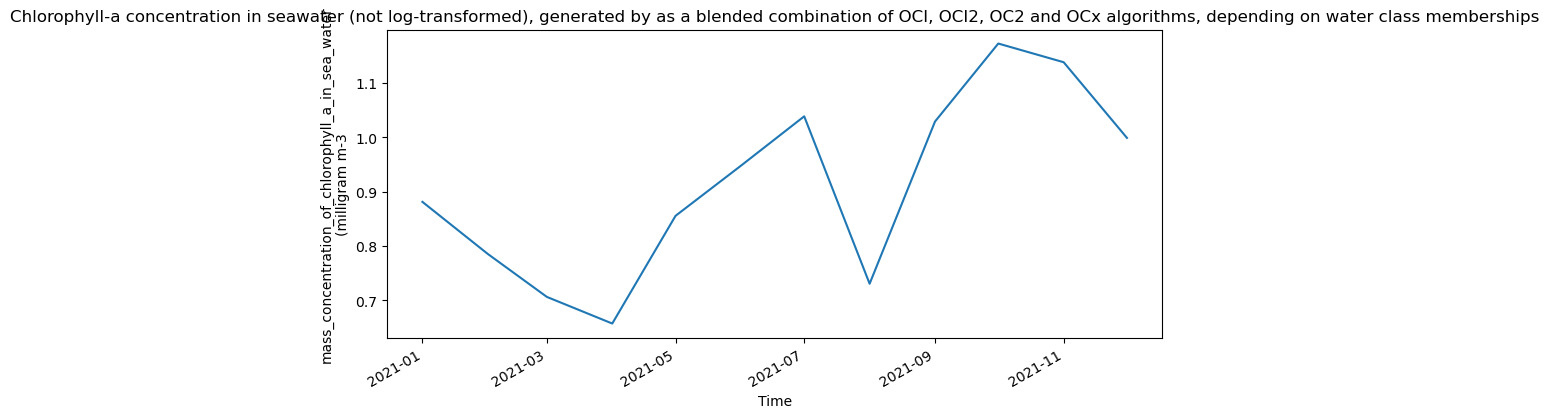

In [45]:
chlora_xypromedio.plot(figsize=(10,4))
plt.ylabel(f"{subset_chlora_da.standard_name}\n({subset_chlora_da.units}")
plt.title(subset_chlora_da.long_name);


### Si tuviéramos más tiempo ...

Crear estadisticas o resumenes por cada una de las ecoregiones magellanicas usando `regionmask`

https://nbviewer.org/github/waterhackweek/waterdata/blob/master/mashup_waterbudget.ipynb

In [46]:
magellanic_regiones = rm.from_geopandas(
    magellanic_gdf, names="ECOREGION", name="ECOREGION"
)

magellanic_regiones

<regionmask.Regions>
Name:     ECOREGION
overlap:  False

Regions:
 39  r39 Channels and Fjords of Southern Chile
 42  r42                             Chiloense
107 r107                    Malvinas/Falklands
122 r122                North Patagonian Gulfs
140 r140                      Patagonian Shelf

[5 regions]

```python
def generate_huc10_ts(regions, ds, dsvarname, crsvar=None):
    """
    Use regionmask to create a gridded mask from the regions and the xarray dataset's
    grid resolution. Copy the variable attributes from the source DataSet to the 
    output DataArray.
    Returns a DataArray
    """
    mask3d = regions.mask_3D(ds, drop=False)

    # Latitude weighting for area-weighted averaging.
    # But it's probably unnecessary for this small geographical extent of the Upper Yakima
    weights = np.cos(np.deg2rad(ds.lat))
    regions_ts = ds[dsvarname].weighted(mask3d * weights).mean(dim=("lat", "lon"))
    # Assign dataarray name, and variable long name and units to region_ts, from ds[dsvarname]
    regions_ts.name = dsvarname
    regions_ts.attrs['long_name'] = ds[dsvarname].attrs['long_name']
    regions_ts.attrs['units'] = ds[dsvarname].attrs['units']
    
    # if present, drop crs variable b/c it's not needed anymore
    if crsvar in ds:
        regions_ts = regions_ts.drop_vars(crsvar)
    
    return regions_ts

daymet_prcp_regions_ts_daily = generate_huc10_ts(uy_huc10_regions, uy_daymet_prcp_ds, 'prcp', crsvar='latitude_longitude')
```